In [0]:
!sudo apt-get install libatlas-base-dev python-dev gfortran pkg-config libfreetype6-dev

!pip install enigma-catalyst

!pip install logbook==1.3.3



Reading package lists... Done
Building dependency tree       
Reading state information... Done
libfreetype6-dev is already the newest version (2.8.1-2ubuntu2).
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
libatlas-base-dev is already the newest version (3.10.3-5).
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
  Found existing installation: Logbook 1.3.3
    Uninstalling Logbook-1.3.3:
      Successfully uninstalled Logbook-1.3.3
ERROR: enigma-catalyst 0.5.21 has requirement Logbook==0.12.5, but you'll have logbook 1.3.3 which is incompatible.
  Found existing installation: Logbook 0.12.5
    Uninstalling Logbook-0.12.5:
      Successfully uninstalled Logbook-0.12.5


In [0]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!ls
!tar xvzf ta-lib-0.4.0-src.tar.gz
!ls
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!ls
!pip install TA-Lib
import talib

--2019-07-19 08:17:46--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-07-19 08:17:46--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://svwh.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-07-19 08:17:46--  https://svwh.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving svwh.dl.sourceforge.ne

In [0]:
!pip install numpy==1.16 

In [0]:
!catalyst ingest-exchange -x binance -f minute -i eth_btc
!catalyst ingest-exchange -x binance -f minute -i ltc_btc
!catalyst ingest-exchange -x binance -f minute -i bnb_btc
!catalyst ingest-exchange -x binance -f minute -i xrp_btc




Trying to ingest exchange bundle binance...
    [====================================]  Ingesting minute price data on binance:  100%             
Trying to ingest exchange bundle binance...
    [====================================]  Ingesting minute price data on binance:  100%             
Trying to ingest exchange bundle binance...
    [====================================]  Ingesting minute price data on binance:  100%             
Trying to ingest exchange bundle binance...
    [====================================]  Ingesting minute price data on binance:  100%             


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout
from keras.optimizers import Adam
from keras import losses
from keras import backend as K
from keras.models import load_model
import random
import os
import tempfile
import time
from collections import deque
import numpy as np
import pandas as pd
import tensorflow as tf
import talib
import math


Using TensorFlow backend.


In [0]:
    
# -*- coding:utf-8 -*-
from abc import abstractmethod


class Agent(object):
    def __init__(self):
        pass
    
    @abstractmethod
    def trade(self, state):
        pass
    
    def train(self):
        pass
    
    @abstractmethod
    def load_model(self, model_path):
        pass
    
    @abstractmethod
    def save_model(self, model_path):
        pass

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

"""
The Actor calss uses a GRU cell that produces the state before it is fed into the fully-connected layers.
There are 2 fully connected layers defined by fc_policy_1 and fc_policy_2 as well as 2 different output layers 
that are also linear layers defined by fc_policy_out and fc_cash_out. 
To read how input data is fed into the network, we look at the forward function.
State is produced as an ouput from the gru cell.
This state is then passed through 2 fully-connected layers (fc_policy_1 and fc_policy2) with a ReLU activation function.
Subsequently, state is passed to both fc_cash_out and fc_policy_out with sigmoid activations to produce
two different outputs; cash and action respectively.
After taking the cash average, the action is produced from the last two lines of the forward function.
This resulting action is what is being called in both trade and train. During trading, 
no weight update is being donce as torch.no_grad() prevents the network weights from being updated, thus, only during 
training are the weights being updated.
"""

class Actor(nn.Module):
    def __init__(self, s_dim, b_dim, rnn_layers=1, dp=0.2):
        super(Actor, self).__init__()
        self.s_dim = s_dim
        self.b_dim = b_dim
        self.rnn_layers = rnn_layers
        self.gru = nn.GRU(self.s_dim, 128, self.rnn_layers, batch_first=True)
        self.fc_policy_1 = nn.Linear(128, 128)
        self.fc_policy_2 = nn.Linear(128, 64)
        self.fc_policy_out = nn.Linear(64, 1)
        self.fc_cash_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dp)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.initial_hidden = torch.zeros(self.rnn_layers, self.b_dim, 128, dtype=torch.float32)

    def forward(self, state, hidden=None, train=False):
        state, h = self.gru(state, hidden)
        if train:
            state = self.dropout(state)
        state = self.relu(self.fc_policy_1(state))
        state = self.relu(self.fc_policy_2(state))
        cash = self.sigmoid(self.fc_cash_out(state))
        action = self.sigmoid(self.fc_policy_out(state)).squeeze(-1).t()
        cash = cash.mean(dim=0)
        action = torch.cat(((1 - cash) * action, cash), dim=-1)
        action = action / (action.sum(dim=-1, keepdim=True) + 1e-10)
        return action, h.data


class DRLAgent(Agent):
    def __init__(self, s_dim, b_dim, batch_length=64, learning_rate=1e-3, rnn_layers=1):
        super().__init__()
        self.s_dim = s_dim
        self.b_dim = b_dim
        self.batch_length = batch_length
        self.pointer = 0
        self.s_buffer = []
        self.d_buffer = []
        self.experience_replay = 30000

        self.train_hidden = None
        self.trade_hidden = None
        self.actor = Actor(s_dim=self.s_dim, b_dim=self.b_dim, rnn_layers=rnn_layers)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)

    def _trade(self, state, train=False):
        with torch.no_grad():
            a, self.trade_hidden = self.actor(state[:, None, :], self.trade_hidden, train=False)
        return a

    def trade(self, state, train=False):
        state_ = torch.tensor(state, dtype=torch.float32)
        action = self._trade(state_, train=train)
        return action.numpy().flatten()

    def train(self):
        self.optimizer.zero_grad()
        rand = random.randint(0, (len(self.s_buffer)+1-self.batch_length))
        s = self.s_buffer[rand:rand+self.batch_length]
        d = self.d_buffer[rand:rand+self.batch_length]
        s = torch.stack(s).permute(1,0,2)
        d = torch.stack(d)
        a_hat, self.train_hidden = self.actor(s, self.train_hidden, train=True)
        reward = -(a_hat[:, :-1] * d).mean()
        reward.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def reset_model(self):
        self.s_buffer = []
        self.d_buffer = []
        self.trade_hidden = None
        self.train_hidden = None
        self.pointer = 0

    def save_transition(self, state, diff):
        if self.pointer < self.experience_replay:
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.d_buffer.append(torch.tensor(diff, dtype=torch.float32))
            self.pointer += 1
        else:
            self.s_buffer.pop(0)
            self.d_buffer.pop(0)
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.d_buffer.append(torch.tensor(diff, dtype=torch.float32))


    def load_model(self, model_path='./DRL_Torch'):
        self.actor = torch.load(model_path + '/model.pkl')

    def save_model(self, model_path='./DRL_Torch'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.actor, model_path + '/model.pkl')

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving model.pkl to model.pkl
User uploaded file "model.pkl" with length 374042 bytes


In [0]:
agent=DRLAgent(b_dim=4,s_dim=36,batch_length=64)
agent.reset_model()
#agent.load_model(model_path='./')

[2019-07-19 12:59:15.674874] INFO: run_algo: Catalyst version 0.5.21
[2019-07-19 12:59:15.676306] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-07-19 12:59:18.680574] INFO: run_algo: running algo in backtest mode
[2019-07-19 12:59:18.696401] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-07-19 12:59:19.599499] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:19.601343] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:20.071187] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:20.072980] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:20.539487] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:20.541177] WARNING: exchange_blotter: skipping 0 amount orders
[2019-

7680 26337 train


[2019-07-19 12:59:52.319950] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:52.321591] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:52.782722] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:52.784142] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:53.245656] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:53.247025] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:54.738400] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:55.243905] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:56.771459] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:57.233133] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:57.234681] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:58.770526] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 12:59:59.235177]

15360 26401 train


[2019-07-19 13:00:24.756410] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:24.757725] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:25.270806] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:25.828520] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:26.333946] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:26.883450] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:27.341691] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:27.342937] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:27.344347] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:27.815423] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:27.816575] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:28.326202] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:32.926957]

23040 26465 train


[2019-07-19 13:00:59.790365] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:00:59.791845] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:01.381679] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:01.929888] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:02.386842] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:02.388156] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:02.389326] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:02.844344] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:03.397692] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:03.897588] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:03.898737] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:04.401903] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:04.403194]

30720 26529 train


[2019-07-19 13:01:31.458311] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:33.000758] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:33.509964] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:34.029914] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:35.545520] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:35.547131] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.018942] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.020669] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.486425] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.487771] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.912772] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.914151] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:01:36.915188]

38400 26593 train


[2019-07-19 13:02:05.714919] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:06.216629] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:07.658619] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:07.659786] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:08.113537] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:08.614716] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:09.070868] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:09.596924] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:10.015240] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:10.511759] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:13.609532] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:14.102878] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:14.603091]

46080 26657 train


[2019-07-19 13:02:34.220040] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:34.685700] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:34.687152] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:35.159483] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:35.683602] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:36.145873] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:36.147325] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:36.622871] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:36.624360] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:37.091115] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:37.092809] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:46.191209] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:02:47.635873]

53760 26721 train


[2019-07-19 13:03:05.669177] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:05.670309] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:06.085845] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:06.087294] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:06.556893] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:06.558191] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:07.032710] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:07.545997] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:17.125843] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:17.627746] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:18.628608] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:19.138556] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:19.648411]

61440 26785 train


[2019-07-19 13:03:38.404236] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:38.859676] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:38.861159] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:39.322929] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:39.324344] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:39.789002] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:39.790318] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.205172] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.206337] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.207250] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.623483] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.624608] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:03:40.626099]

69120 26849 train


[2019-07-19 13:04:09.518534] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:10.022444] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:14.631110] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:15.131434] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:15.654466] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:16.109992] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:16.111218] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:16.568748] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:17.076564] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:19.573714] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:23.890097] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:24.397525] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:24.862727]

76800 26913 train


[2019-07-19 13:04:42.432607] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:42.891421] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:44.929801] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:45.384978] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:45.881461] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:46.339968] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:46.341246] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:46.767105] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:46.768236] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:47.229355] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:47.730149] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:48.323640] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:04:48.847609]

84480 26977 train


[2019-07-19 13:05:16.127712] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:16.649992] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:16.651401] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:17.142724] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:17.144128] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:17.662557] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:18.202593] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:18.691607] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:18.693041] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:19.190266] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:19.191812] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:19.685166] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:21.932947]

92160 27041 train


[2019-07-19 13:05:52.316506] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:52.801204] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:05:53.293407] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:03.724989] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:05.232563] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:05.691455] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:05.692821] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:06.146414] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:07.140754] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:09.061920] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:09.573507] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:10.074481] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:10.568233]

99840 27105 train


[2019-07-19 13:06:24.851204] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:24.852446] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:25.311951] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:25.313080] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:25.769941] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:25.771231] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:26.226467] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:26.227539] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:26.690594] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:26.691858] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:27.147608] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:27.148746] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:27.606502]

107520 27169 train


[2019-07-19 13:06:52.840585] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:53.307918] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:53.309045] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:53.781678] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:53.782980] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:54.243771] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:54.750866] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:55.254606] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:55.758405] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:56.260151] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:56.762140] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:58.288754] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:06:58.786418]

115200 27233 train


[2019-07-19 13:07:27.025887] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:29.041673] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:29.547902] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:32.682014] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:33.187691] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:33.643233] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:34.629463] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:35.131853] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:41.483285] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:42.016977] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:43.538512] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:43.952413] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:45.457879]

122880 27297 train


[2019-07-19 13:07:57.880479] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:57.881516] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:58.302672] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:58.303931] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:59.262880] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:07:59.775461] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:00.764019] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:01.262632] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:03.786914] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:04.284566] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:05.801708] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:06.294737] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:09.871904]

130560 27361 train


[2019-07-19 13:08:29.022830] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:29.489621] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:29.490844] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:29.951518] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:29.952847] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:30.370611] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:30.371689] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:35.470065] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:35.933476] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:36.437887] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:36.945909] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:37.447172] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:08:39.466227]

138240 27425 train


[2019-07-19 13:09:01.347736] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:01.847354] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:02.255997] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:02.257450] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:02.258367] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:02.672451] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:02.673775] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:03.131159] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:04.135860] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:05.615153] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:06.111270] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:10.607264] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:11.104958]

145920 27489 train


[2019-07-19 13:09:33.585151] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:34.134209] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:34.673197] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:35.165333] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:35.701988] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:36.211570] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:36.746004] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:37.245075] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:37.246439] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:37.737342] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:37.738482] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:38.197346] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:09:38.198466]

153600 27553 train


[2019-07-19 13:10:07.056901] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:09.332773] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:09.878792] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:10.375207] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:10.376393] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:10.873616] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:10.874752] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:11.377629] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:11.931540] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:12.509127] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:13.051311] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:26.960645] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:27.466687]

161280 27617 train


[2019-07-19 13:10:41.455578] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:45.649123] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:50.140298] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:52.205420] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:54.786398] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:10:59.924895] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:01.469433] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:01.968318] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:02.466228] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:02.969605] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:03.475678] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:03.988236] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:04.502784]

168960 27681 train


[2019-07-19 13:11:12.503610] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:13.005266] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:16.565634] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:17.572173] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:18.072461] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:18.572275] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:23.741544] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:24.240720] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:24.735747] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:25.191384] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:25.689925] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:26.146737] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:11:28.204086]

176640 27745 train


[2019-07-19 13:11:50.344990] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:13.272042] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:13.729180] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:14.684337] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:17.158164] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:17.159736] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:17.621007] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:17.622593] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:18.086534] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:18.087938] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:18.546805] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:18.548407] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:19.006809]

184320 27809 train


[2019-07-19 13:12:36.935006] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:37.432641] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:40.561104] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:51.529171] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:51.951409] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:52.454402] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:56.553671] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:57.047039] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:57.500304] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:12:59.034414] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:00.546436] WARNING: exchange_blotter: skipping 0 amount orders


192000 27873 train


[2019-07-19 13:13:08.289515] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:08.745936] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:08.747226] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:09.202832] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:09.698381] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:10.150291] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:10.151590] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:10.609418] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:10.610535] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:11.020545] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:11.021709] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:11.022761] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:11.436672]

199680 27937 train


[2019-07-19 13:13:39.425871] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:39.427159] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:39.428563] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:39.840511] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:39.841709] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:39.842904] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:40.258742] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:40.260021] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:40.261223] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:40.674461] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:44.767651] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:47.816670] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:13:48.309652]

207360 28001 train


[2019-07-19 13:14:10.785498] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:11.240587] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:11.242195] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:11.701653] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:11.703551] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:12.161424] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:12.163115] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:12.616411] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:12.617871] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:13.072870] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:13.074289] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:17.185491] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:14:17.634667]

215040 28065 train


[2019-07-19 13:14:47.796404] INFO: DQN script: Total reward: 0.7344827418621857, portfolio: 1.2502410628731948
[2019-07-19 13:15:03.296449] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:03.297768] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:03.755211] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:04.284312] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:04.813730] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:08.698682] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:09.181557] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:09.182813] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:09.670659] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:10.200497] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:10.644380] WARNING: exchange_blotter: skipping 0 amount order

222720 28129 train


[2019-07-19 13:15:17.577395] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:17.578437] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:18.029962] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:18.520396] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:19.012957] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:24.667402] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:25.164457] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:25.655868] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:26.147808] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:26.642757] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:29.184802] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:29.643305] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:29.644736]

230400 28193 train


[2019-07-19 13:15:51.675884] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:52.131244] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:52.132815] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:52.615152] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:53.117992] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:53.620882] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:54.056173] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:54.567516] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:55.066503] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:55.569730] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:55.992520] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:56.481125] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:15:56.482523]

238080 28257 train


[2019-07-19 13:16:28.616965] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:29.111124] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:31.188626] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:34.222023] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:36.786776] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:37.265001] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:37.761684] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:38.220466] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:39.692126] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:39.693436] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:39.694472] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:40.117581] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:16:40.118784]

245760 28321 train
253440 28385 train


[2019-07-19 13:17:31.400766] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:45.060545] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:47.642770] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:48.142244] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:49.684321] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:51.217392] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:51.717765] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:52.224656] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:52.726322] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:52.727938] INFO: DQN script: Total reward: 0.8270598180617104, portfolio: 1.2103447068360236
[2019-07-19 13:17:53.145731] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:17:53.147207] WARNING: exchange_blotter: skipping 0 amount order

261120 28449 train


[2019-07-19 13:18:03.277456] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:25.711194] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:26.208423] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:26.663205] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:28.220622] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:30.274729] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:30.276199] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:30.742855] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:30.744178] WARNING: exchange_blotter: skipping 0 amount orders


268800 28513 train


[2019-07-19 13:18:38.160561] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:38.654543] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:39.148252] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:39.670606] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:40.166366] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:41.602633] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:41.603774] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:42.056120] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:43.046134] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:43.498376] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:43.499888] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:43.975700] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:18:43.976998]

276480 28577 train


[2019-07-19 13:19:09.963542] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:10.424305] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:10.425749] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:10.844697] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:10.845997] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:10.847184] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.264171] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.265465] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.266798] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.682463] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.683738] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:11.685155] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:12.104170]

284160 28641 train


[2019-07-19 13:19:39.822638] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:39.823776] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.248788] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.250106] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.251117] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.676705] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.678086] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:40.679353] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:41.099830] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:41.100967] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:41.101968] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:41.518620] WARNING: exchange_blotter: skipping 0 amount orders
[2019-07-19 13:19:41.519802]

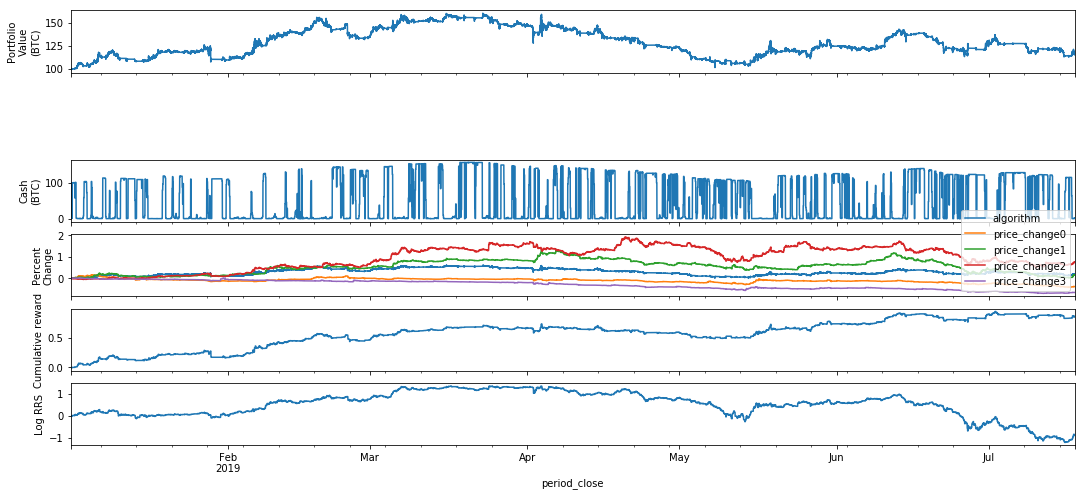

[2019-07-19 13:20:24.163555] INFO: DQN script: saved perf stats: /tmp/catalyst/DQN script/20190719-125915.p


In [0]:

#Talib used to create ATR indicator

from logbook import Logger

from catalyst import run_algorithm
from catalyst.api import symbol, symbols, record, order_target_percent, order, order_target
from catalyst.exchange.utils.stats_utils import extract_transactions
from catalyst.utils.paths import ensure_directory





NAMESPACE = 'DQN script'
log = Logger(NAMESPACE)


def initialize(context):
    context.assets = symbols('eth_btc', 'ltc_btc', 'bnb_btc', 'xrp_btc')
    context.nassets = 4
    context.base_price = None
    context.current_day = None
    context.set_commission(maker=0.001, taker=0.001)
    
    # Parameters to tune trailing ATR stop
    

    context.start_time = time.time()

    context.i = 0
    context.counter = 0
    
    context.bought = 0
    context.in_position = 0
    context.buy_price = 0
    context.portfolio_initial = None
    
    context.reward = 0
    context.rewards = []
    context.action = 0
    context.state_size = 600
    context.agent = agent
    context.total_reward = 0
    context.total_loss = 0
    context.state = None
    context.next_state = None
    context.done = False
    context.train_freq = 10
    context.batch_size = 32
    context.update_q_freq = 30
    context.num_buy = 0
    context.num_sell = 0
    context.num_hold = 0
    context.state_part = 0
    context.num_pos_rewards = 0
    context.prev_portfolio = 0
    context.nontradeperiod = 0
    context.prev_price = 0
    context.trade_flow = np.zeros((1, 90, 1))
    context.current_weight = np.concatenate((np.zeros((context.nassets)), [1.]))
    context.norm_len = 10
    context.rrs = 0

    
def get_indicators(security, open_name, close_name, high_name, low_name, volume_name):
        open_price = security[open_name].values
        close_price = security[close_name].values
        low_price = security[low_name].values
        high_price = security[high_name].values
        volume = security[volume_name].values if volume_name else None
        security['MOM'] = talib.MOM(close_price)
        security['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_price)
        security['HT_DCPHASE'] = talib.HT_DCPHASE(close_price)
        security['SINE'], security['LEADSINE'] = talib.HT_SINE(close_price)
        security['INPHASE'], security['QUADRATURE'] = talib.HT_PHASOR(close_price)
        security['ADXR'] = talib.ADXR(high_price, low_price, close_price)
        security['APO'] = talib.APO(close_price)
        security['AROON_UP'], _ = talib.AROON(high_price, low_price)
        security['CCI'] = talib.CCI(high_price, low_price, close_price)
        security['PLUS_DI'] = talib.PLUS_DI(high_price, low_price, close_price)
        security['PPO'] = talib.PPO(close_price)
        security['MACD'], security['MACD_SIG'], security['MACD_HIST'] = talib.MACD(close_price)
        security['CMO'] = talib.CMO(close_price)
        security['ROCP'] = talib.ROCP(close_price)
        security['FASTK'], security['FASTD'] = talib.STOCHF(high_price, low_price, close_price)
        security['TRIX'] = talib.TRIX(close_price)
        security['ULTOSC'] = talib.ULTOSC(high_price, low_price, close_price)
        security['WILLR'] = talib.WILLR(high_price, low_price, close_price)
        security['NATR'] = talib.NATR(high_price, low_price, close_price)
        security['RSI'] = talib.RSI(close_price)
        security['EMA'] = talib.EMA(close_price)
        security['SAREXT'] = talib.SAREXT(high_price, low_price)
        # security['TEMA'] = talib.EMA(close_price)
        security['RR'] = security[close_name] / security[close_name].shift(1).fillna(1)
        security['LOG_RR'] = np.log(security['RR'])
        if volume_name:
            security['MFI'] = talib.MFI(high_price, low_price, close_price, volume)
            # security['AD'] = talib.AD(high_price, low_price, close_price, volume)
            # security['OBV'] = talib.OBV(close_price, volume)
            security[volume_name] = np.log(security[volume_name])
        #security.drop([open_name, close_name, high_name, low_name], axis=1)
        security = security.dropna().astype(np.float32)
        return security
      
def get_normalized_state(preprocessed_market_data, normalize_length, current_weight):
        data = preprocessed_market_data.iloc[:,-normalize_length:, :].values
        state = ((data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-10))[:, -1, :]
        inds = np.where(np.isnan(state))
        state[inds] = 0
        return np.concatenate((state, current_weight[:-1][:, None]), axis=1)

def get_reward(current_price, next_price, current_weight):
        return_rate = (next_price / current_price)
        log_return = np.log(return_rate)
        last_weight = current_weight.copy()
        reward = last_weight[:-1] * log_return
        return reward


def handle_data(context, data):
    
    context.i += 1
    if context.i % 120 != 0:
        return
      
    df = {}
    #next_log_rr = np.zeros(context.nassets)
    for i in range(context.nassets):
        security = data.history(
        context.assets[i],
        fields=['open', 'high', 'low', 'close', 'volume'],
        bar_count=100,
        frequency='2H'
        )
        security = security.fillna(axis='columns', method='ffill').fillna(axis='columns', method='bfill')
        security['volume'] = security['volume'].replace(0, np.nan).fillna(method='ffill')
        security = get_indicators(security, 'open', 'close', 'high', 'low', 'volume')
        df.update({i: security})
        #next_log_rr[i] = security['LOG_RR'].iloc[-1]
    

    panel = pd.Panel(df)
    

    next_state = get_normalized_state(panel, context.norm_len, context.current_weight)
 


    current = data.current(context.assets, fields=['close'])
    price = current['close']
    reward = 0
    total_reward = 0
    rrs = 0
    
    
    

    if context.base_price is None:
        context.base_price = price
        context.portfolio_initial = context.portfolio.portfolio_value
        context.prev_price = price
        
    next_log_rr = np.array(np.log(price/context.prev_price))
    rrs = np.sum(next_log_rr) + context.rrs
    context.rrs += np.sum(next_log_rr)


    
    
        
    if context.i > 120:
        
        #if price.all() == context.prev_price.all():
            #return
        #print(context.current_weight[:-1], next_log_rr)
        
        reward = get_reward(context.prev_price, price, context.current_weight)

        

        
        total_reward = np.sum(context.total_reward + reward)
        context.total_reward += reward

        
        context.agent.save_transition(state=context.state,diff=next_log_rr)
        
        
        
        if context.i % 7680 == 0:
            context.agent.train()
            print(context.i, len(agent.s_buffer), 'train')

     

    context.state = next_state

    context.action = context.agent.trade(context.state,train=True)
    

    #assert context.action[0] >= 0, 'Action: {}'.format(torch.tensor(context.state, dtype=torch.float32))
    #assert context.action[0] <= 1, 'Action: {}'.format(context.action)

        
    
    price_change = (price - context.base_price) / context.base_price


    cash = context.portfolio.cash


    orders = context.blotter.open_orders
    
    if len(orders) > 0:
        log.info('exiting because orders are open: {}'.format(orders))
        return

    # Exit if we cannot trade
    #if not data.can_trade(context.assets):
        #return

    for i in range(context.nassets):   
        order_target(context.assets[i], round((context.action[i] * context.portfolio.portfolio_value) / price[i], 6))

    
    #for asset in context.assets:
        #pos_amount = context.portfolio.positions[asset].amount
        #print(asset, pos_amount / context.portfolio.portfolio_value)
    


    if context.i % 43200 == 0:
       log.info('Total reward: {}, portfolio: {}'.format(total_reward, context.portfolio.portfolio_value / context.portfolio_initial))
        
      

    record(
        #price=price,
        price_change0=price_change[0],
        price_change1=price_change[1],
        price_change2=price_change[2],
        price_change3=price_change[3],
        #price_change=price_change,
        cash=cash,
        reward=total_reward,
        counter=context.i,
        rrs = rrs,
        action=context.action
    )
    
    context.prev_price = price
    context.prev_portfolio = context.portfolio.portfolio_value

    context.current_weight = context.action
    
        

def analyze(context, perf):
    end = time.time()
    log.info('elapsed time: {}'.format(end - context.start_time))

    import matplotlib.pyplot as plt
    # The quote currency of the algo exchange
    quote_currency = list(context.exchanges.values())[0].quote_currency.upper()

    # Plot the portfolio value over time.
    ax1 = plt.subplot(611)
    perf.loc[:, 'portfolio_value'].plot(ax=ax1)
    ax1.set_ylabel('Portfolio\nValue\n({})'.format(quote_currency))

    # Plot the price increase or decrease over time.
    """ax2 = plt.subplot(612, sharex=ax1)
    perf.loc[:, 'price'].plot(ax=ax2, label='Price')

    ax2.set_ylabel('{asset}\n({quote})'.format(
        asset=context.asset, quote=quote_currency
    ))

    transaction_df = extract_transactions(perf)
    if not transaction_df.empty:
        buy_df = transaction_df[transaction_df['amount'] > 0]
        sell_df = transaction_df[transaction_df['amount'] < 0]
        ax2.scatter(
            buy_df.index.to_pydatetime(),
            perf.loc[buy_df.index.floor('1 min'), 'price'],
            marker='^',
            s=100,
            c='green',
            label=''
        )
        ax2.scatter(
            sell_df.index.to_pydatetime(),
            perf.loc[sell_df.index.floor('1 min'), 'price'],
            marker='v',
            s=100,
            c='red',
            label=''
        )"""

    ax4 = plt.subplot(613, sharex=ax1)
    perf.loc[:, 'cash'].plot(
        ax=ax4, label='Quote Currency ({})'.format(quote_currency)
    )
    ax4.set_ylabel('Cash\n({})'.format(quote_currency))

    perf['algorithm'] = perf.loc[:, 'algorithm_period_return']

    ax5 = plt.subplot(614, sharex=ax1)
    perf.loc[:, ['algorithm', 'price_change0', 'price_change1', 'price_change2', 'price_change3']].plot(ax=ax5)
    #perf.loc[:, ['algorithm', 'price_change']].plot(ax=ax5)
    ax5.set_ylabel('Percent\nChange')
    
    ax6 = plt.subplot(615, sharex=ax1)
    perf.loc[:, 'reward'].astype(float).plot(ax=ax6)
    ax6.set_ylabel('Cumulative reward')
    
    ax7 = plt.subplot(616, sharex=ax1)
    perf.loc[:, 'rrs'].astype(float).plot(ax=ax7)
    ax7.set_ylabel('Log RRS')
    
    
    
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.show()
    #print('Epoch total reward: {}'.format(perf.loc[:, 'reward'][-1]))
    pass
        
    

if __name__ == '__main__':
    # The execution mode: backtest or live
    live = False

    if live:
        run_algorithm(
            capital_base=0.1,
            initialize=initialize,
            handle_data=handle_data,
            analyze=analyze,
            exchange_name='binance',
            live=True,
            algo_namespace=NAMESPACE,
            quote_currency='eth',
            live_graph=False,
            simulate_orders=False,
            stats_output=None,
            # auth_aliases=dict(poloniex='auth2')
        )

    else:
        folder = os.path.join(
            tempfile.gettempdir(), 'catalyst', NAMESPACE
        )
        ensure_directory(folder)
  
        timestr = time.strftime('%Y%m%d-%H%M%S')
        out = os.path.join(folder, '{}.p'.format(timestr))
        for e in range(1):
            run_algorithm(
                capital_base=100.0,
                data_frequency='minute',
                initialize=initialize,
                handle_data=handle_data,
                analyze=analyze,
                exchange_name='binance',
                algo_namespace=NAMESPACE,
                quote_currency='btc',
                start=pd.to_datetime('2019-01-01', utc=True).tz_convert('UTC'),
                end=pd.to_datetime('2019-07-17', utc=True).tz_convert('UTC'),
                output=out
                )
        log.info('saved perf stats: {}'.format(out))


In [0]:
agent.save_model()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
perf = pd.read_pickle('/tmp/catalyst/DQN script/20190719-125915.p') # read in perf DataFrame
pv = perf.loc[:, 'portfolio_value']
pr=pv.pct_change()
print(pr.head())

period_close
2019-01-01 00:01:00+00:00    NaN
2019-01-01 00:02:00+00:00    0.0
2019-01-01 00:03:00+00:00    0.0
2019-01-01 00:04:00+00:00    0.0
2019-01-01 00:05:00+00:00    0.0
Name: portfolio_value, dtype: float64


[2019-07-19 13:23:27.180996] INFO: run_algo: Catalyst version 0.5.21
[2019-07-19 13:23:27.182451] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-07-19 13:23:30.186361] INFO: run_algo: running algo in backtest mode
[2019-07-19 13:23:30.192601] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-07-19 13:38:44.264688] INFO: Performance: Simulated 198 trading days out of 198.
[2019-07-19 13:38:44.265866] INFO: Performance: first open: 2019-01-01 00:00:00+00:00
[2019-07-19 13:38:44.266754] INFO: Performance: last close: 2019-07-17 23:59:00+00:00
[2019-07-19 13:38:49.663122] INFO: DQN script: elapsed time: 919.4592392444611


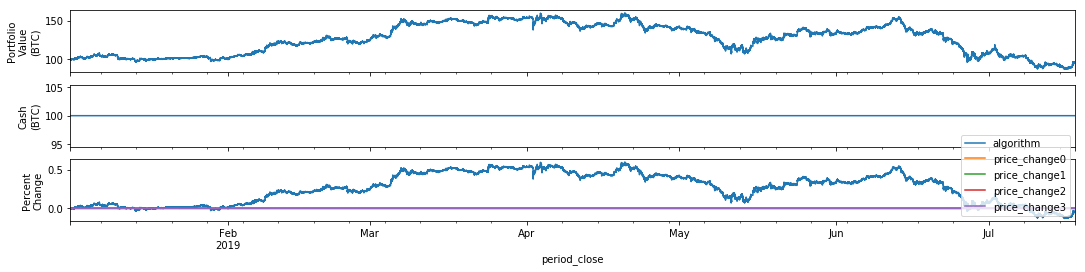

[2019-07-19 13:39:36.191559] INFO: DQN script: saved perf stats: /tmp/catalyst/DQN script/20190719-132327.p


In [0]:

#Talib used to create ATR indicator

from logbook import Logger

from catalyst import run_algorithm
from catalyst.api import symbol, symbols, record, order_target_percent, order, order_target
from catalyst.exchange.utils.stats_utils import extract_transactions
from catalyst.utils.paths import ensure_directory





NAMESPACE = 'DQN script'
log = Logger(NAMESPACE)


def initialize(context):
    context.assets = symbols('eth_btc', 'ltc_btc', 'bnb_btc', 'xrp_btc')
    context.nassets = 4
    context.base_price = None
    context.current_day = None
    context.set_commission(maker=0.001, taker=0.001)
    
    # Parameters to tune trailing ATR stop
    

    context.start_time = time.time()

    context.i = 0
    context.counter = 0
    
    context.bought = 0
    context.in_position = 0
    context.buy_price = 0
    context.portfolio_initial = None
    
    context.reward = 0
    context.rewards = []
    context.action = 0
    context.state_size = 600
    context.agent = agent
    context.total_reward = 0
    context.total_loss = 0
    context.state = None
    context.next_state = None
    context.done = False
    context.train_freq = 10
    context.batch_size = 32
    context.update_q_freq = 30
    context.num_buy = 0
    context.num_sell = 0
    context.num_hold = 0
    context.state_part = 0
    context.num_pos_rewards = 0
    context.prev_portfolio = 0
    context.nontradeperiod = 0
    context.prev_price = 0
    context.trade_flow = np.zeros((1, 90, 1))
    context.current_weight = np.concatenate((np.zeros((context.nassets)), [1.]))
    context.norm_len = 10
    context.rrs = 0

    
def get_indicators(security, open_name, close_name, high_name, low_name, volume_name):
        open_price = security[open_name].values
        close_price = security[close_name].values
        low_price = security[low_name].values
        high_price = security[high_name].values
        volume = security[volume_name].values if volume_name else None
        security['MOM'] = talib.MOM(close_price)
        security['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_price)
        security['HT_DCPHASE'] = talib.HT_DCPHASE(close_price)
        security['SINE'], security['LEADSINE'] = talib.HT_SINE(close_price)
        security['INPHASE'], security['QUADRATURE'] = talib.HT_PHASOR(close_price)
        security['ADXR'] = talib.ADXR(high_price, low_price, close_price)
        security['APO'] = talib.APO(close_price)
        security['AROON_UP'], _ = talib.AROON(high_price, low_price)
        security['CCI'] = talib.CCI(high_price, low_price, close_price)
        security['PLUS_DI'] = talib.PLUS_DI(high_price, low_price, close_price)
        security['PPO'] = talib.PPO(close_price)
        security['MACD'], security['MACD_SIG'], security['MACD_HIST'] = talib.MACD(close_price)
        security['CMO'] = talib.CMO(close_price)
        security['ROCP'] = talib.ROCP(close_price)
        security['FASTK'], security['FASTD'] = talib.STOCHF(high_price, low_price, close_price)
        security['TRIX'] = talib.TRIX(close_price)
        security['ULTOSC'] = talib.ULTOSC(high_price, low_price, close_price)
        security['WILLR'] = talib.WILLR(high_price, low_price, close_price)
        security['NATR'] = talib.NATR(high_price, low_price, close_price)
        security['RSI'] = talib.RSI(close_price)
        security['EMA'] = talib.EMA(close_price)
        security['SAREXT'] = talib.SAREXT(high_price, low_price)
        # security['TEMA'] = talib.EMA(close_price)
        security['RR'] = security[close_name] / security[close_name].shift(1).fillna(1)
        security['LOG_RR'] = np.log(security['RR'])
        if volume_name:
            security['MFI'] = talib.MFI(high_price, low_price, close_price, volume)
            # security['AD'] = talib.AD(high_price, low_price, close_price, volume)
            # security['OBV'] = talib.OBV(close_price, volume)
            security[volume_name] = np.log(security[volume_name])
        #security.drop([open_name, close_name, high_name, low_name], axis=1)
        security = security.dropna().astype(np.float32)
        return security
      
def get_normalized_state(preprocessed_market_data, normalize_length, current_weight):
        data = preprocessed_market_data.iloc[:,-normalize_length:, :].values
        state = ((data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-10))[:, -1, :]
        inds = np.where(np.isnan(state))
        state[inds] = 0
        return np.concatenate((state, current_weight[:-1][:, None]), axis=1)

def get_reward(current_price, next_price, current_weight):
        return_rate = (next_price / current_price)
        log_return = np.log(return_rate)
        last_weight = current_weight.copy()
        reward = last_weight[:-1] * log_return
        return reward


def handle_data(context, data):
    
    context.i += 1
    if context.i > 1:
        return

    df = {}
    #next_log_rr = np.zeros(context.nassets)
 


    current = data.current(context.assets, fields=['close'])
    price = current['close']

    
    

    if context.base_price is None:
        context.base_price = price
        context.portfolio_initial = context.portfolio.portfolio_value
        context.prev_price = price
        for i in range(context.nassets):   
            order_target_percent(context.assets[i], 1/context.nassets)
    
    price_change = (price - context.base_price) / context.base_price
    cash = context.portfolio.cash
    
    record(
        #price=price,
        price_change0=price_change[0],
        price_change1=price_change[1],
        price_change2=price_change[2],
        price_change3=price_change[3],
        #price_change=price_change,
        cash=cash
    )
    
    context.prev_price = price
    context.prev_portfolio = context.portfolio.portfolio_value

    context.current_weight = context.action
    
        

def analyze(context, perf):
    end = time.time()
    log.info('elapsed time: {}'.format(end - context.start_time))

    import matplotlib.pyplot as plt
    # The quote currency of the algo exchange
    quote_currency = list(context.exchanges.values())[0].quote_currency.upper()

    # Plot the portfolio value over time.
    ax1 = plt.subplot(611)
    perf.loc[:, 'portfolio_value'].plot(ax=ax1)
    ax1.set_ylabel('Portfolio\nValue\n({})'.format(quote_currency))


    ax4 = plt.subplot(612, sharex=ax1)
    perf.loc[:, 'cash'].plot(
        ax=ax4, label='Quote Currency ({})'.format(quote_currency)
    )
    ax4.set_ylabel('Cash\n({})'.format(quote_currency))

    perf['algorithm'] = perf.loc[:, 'algorithm_period_return']

    ax5 = plt.subplot(613, sharex=ax1)
    perf.loc[:, ['algorithm', 'price_change0', 'price_change1', 'price_change2', 'price_change3']].plot(ax=ax5)
    #perf.loc[:, ['algorithm', 'price_change']].plot(ax=ax5)
    ax5.set_ylabel('Percent\nChange')
    
    
    
    
    # Show the plot.
    plt.gcf().set_size_inches(18, 8)
    plt.show()
    #print('Epoch total reward: {}'.format(perf.loc[:, 'reward'][-1]))
    pass
        
    

if __name__ == '__main__':
    # The execution mode: backtest or live
    live = False

    if live:
        run_algorithm(
            capital_base=0.1,
            initialize=initialize,
            handle_data=handle_data,
            analyze=analyze,
            exchange_name='binance',
            live=True,
            algo_namespace=NAMESPACE,
            quote_currency='eth',
            live_graph=False,
            simulate_orders=False,
            stats_output=None,
            # auth_aliases=dict(poloniex='auth2')
        )

    else:
        folder = os.path.join(
            tempfile.gettempdir(), 'catalyst', NAMESPACE
        )
        ensure_directory(folder)
  
        timestr = time.strftime('%Y%m%d-%H%M%S')
        out = os.path.join(folder, '{}.p'.format(timestr))
        for e in range(1):
            run_algorithm(
                capital_base=100.0,
                data_frequency='minute',
                initialize=initialize,
                handle_data=handle_data,
                analyze=analyze,
                exchange_name='binance',
                algo_namespace=NAMESPACE,
                quote_currency='btc',
                start=pd.to_datetime('2019-01-01', utc=True).tz_convert('UTC'),
                end=pd.to_datetime('2019-07-17', utc=True).tz_convert('UTC'),
                output=out
                )
        log.info('saved perf stats: {}'.format(out))


In [0]:
perf = pd.read_pickle('/tmp/catalyst/DQN script/20190719-132327.p') # read in perf DataFrame
bpv = perf.loc[:, 'portfolio_value']
bpr=bpv.pct_change()
print(bpr.head())

period_close
2019-01-01 00:01:00+00:00         NaN
2019-01-01 00:02:00+00:00    0.000000
2019-01-01 00:03:00+00:00   -0.001100
2019-01-01 00:04:00+00:00   -0.001220
2019-01-01 00:05:00+00:00    0.000491
Name: portfolio_value, dtype: float64


In [0]:
!pip install pyfolio

Start date,2019-01-01
End date,2019-07-18
Total months,13577
,Backtest
Annual return,0.0%
Cumulative returns,16.7%
Annual volatility,1.4%
Sharpe ratio,0.02
Calmar ratio,0.00
Stability,0.00
Max drawdown,-36.9%


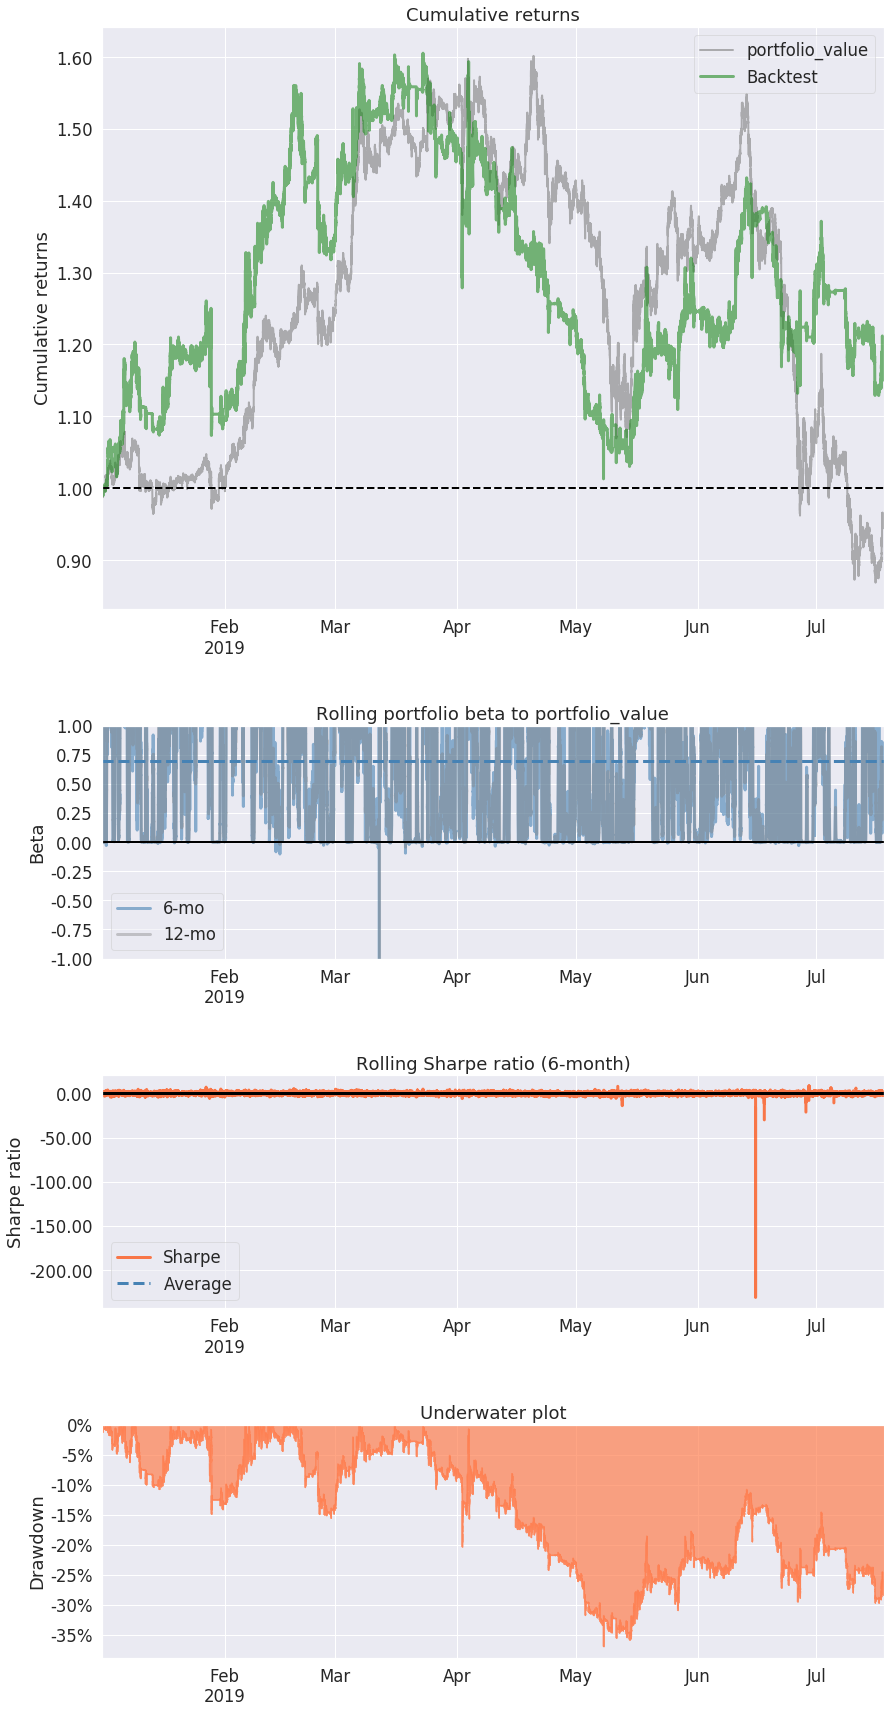

In [0]:
import pyfolio as pf
pf.create_simple_tear_sheet(returns=pr,benchmark_rets=bpr)